##### Ayshwarya Sambasivan
##### Crime prediction Using Classification algorithms

In [1]:
import os
import copy
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier

# since we are performing cross validation and classification reports on a number of models, a wrapper class 
# is used to run the cross_val_score function and extract scores required
class CS595ModelClassificationScoring(object):
    def __init__(self, model_object=None, train_data=None, target_data=None, model_name=None):
        self.model_object = model_object
        self.train_data = train_data
        self.target_data = target_data
        self.model_name = model_name if model_name is not None else "model"
        self.full_model = None
    def cross_validate(self, num_folds=10, scorers=["accuracy", "precision", "recall", "f1"]):
        print("\n{} performace on cross validation:".format(self.model_name))
        all_scores = []
        for scorer in scorers:
            scores = cross_val_score(copy.deepcopy(self.model_object),  # steps to convert raw messages into models
                                     self.train_data,  # training data
                                     self.target_data,  # training labels
                                     cv=num_folds,# split data randomly into num_folds parts: num_folds-1 for training, 1 for scoring
                                     scoring=scorer,  # scoring metric
                                     n_jobs=-1,  # -1 = use all cores = faster
                                     )
            all_scores.append({'score_name': scorer, 'scores': scores, 'mean': scores.mean(), 'std': scores.std()})
        self.print_cross_val_scores(num_folds, self.model_name, all_scores)

    def full_data_fit_score(self, target_names=None, print_report='clf'):
        self.full_model = copy.deepcopy(self.model_object)
        self.full_model.fit(self.train_data, self.target_data)
        if print_report=='clf':
            print("\n{} performace on training with full data:".format(self.model_name))
            print_classification_report(self.full_model, self.train_data, self.target_data, target_names)
        else: 
            print("\n{} performace on training with full data:".format(self.model_name))
            predicted_data = self.full_model.predict(self.train_data)
            print("\tMSE of the model is {}".format(mean_squared_error(self.target_data, predicted_data)))
            print(u"\tR\u00B2 of the model is {}".format(r2_score(self.target_data, predicted_data)))

    def __iter__(self):
        if self.score_dict:
            for score_name in self.score_names:
                yield self.score_dict[score_name]

    def print_cross_val_scores(self, num_folds, model_name, model_scores):
        print("\nThe {}-fold cross-validation {} for the {} model are: ".format(num_folds, ', '.join(
            [scores['score_name'] for scores in model_scores]), model_name))
        for scores in model_scores:
            print(u"\t{:{}s}: {:{}f}(\u00B1{})".format(scores['score_name'], 22, round(scores['mean'], 4), 2,
                                                       round(scores['std'], 2)))


# helper function to calculate and print classification report            
def print_classification_report(trained_model_object, train_data, target_data, target_names):
    predicted_data = trained_model_object.predict(train_data)
    print("Accuracy of the model is {}".format(accuracy_score(target_data, predicted_data)))
    print(classification_report(target_data, predicted_data, target_names=target_names))


# helper function to print feature importances
def show_feature_importances(importances_list, variable_list, model_name="", topn=10, sort_order_ascending=False, print_leading=True):
    feature_importances = pd.DataFrame(importances_list, columns=["Feature Importance"], index=variable_list) \
        .sort_values(["Feature Importance"], ascending=sort_order_ascending)
    if print_leading:
        print("\nThe 10 most predictive features of the {} are : ".format(model_name))
    print(feature_importances.dropna().head(topn))


In [2]:
# initialize some dictionaries to hold scorers and models
scorers = {}

# set up data file paths
data_folder = 'Crime Prediction Data'
data_path = os.path.join(os.path.dirname(os.path.realpath('__file__')), data_folder)
full_data_file = os.path.join(data_path, 'communities-crime-full.csv')
clean_data_file = os.path.join(data_path, 'communities-crime-clean.csv')

# read clean data file
clean_data_df = pd.read_csv(clean_data_file)

# set up predictor variables and target variables
target_variable_clf = 'highCrime'
target_variable_reg = 'ViolentCrimesPerPop'
non_predictors = {target_variable_reg, target_variable_clf, 'communityname', 'fold', 'state', 'county', 'community'} 
predictor_variables =  [col for col in clean_data_df if col not in non_predictors]
clf_target_names = ['Low crime', 'High crime']

clean_data_df.head()

,state,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,Alabastercity,7,0.01,0.61,0.21,0.83,0.02,0.01,0.41,...,0.03,0.70,0.40,0.34,0.57,0.05,0.06,0.01,0.0,0.06
1,1,AlexanderCitycity,10,0.01,0.41,0.55,0.57,0.01,0.00,0.47,...,0.00,0.93,0.66,0.82,0.84,0.11,0.03,0.01,0.0,0.14
2,1,Annistoncity,3,0.03,0.34,0.86,0.30,0.04,0.01,0.41,...,0.04,0.77,0.59,0.70,0.64,0.06,0.11,0.04,0.0,1.00
3,1,Athenscity,8,0.01,0.38,0.35,0.71,0.04,0.01,0.39,...,0.03,0.78,0.56,0.67,0.71,0.09,0.05,0.00,0.0,0.23
4,1,Auburncity,1,0.04,0.37,0.32,0.70,0.21,0.02,1.00,...,0.12,0.49,0.12,0.00,0.15,0.09,0.09,0.01,0.0,0.15


# 1.	Decision Trees


In [3]:
# percentage of positive and negative instances of per capita crime rate (ViolentCrimesPerPop) greater than 0.1
clean_data_df[target_variable_clf] = clean_data_df['ViolentCrimesPerPop'] > 0.1
pct_high_crime = clean_data_df[target_variable_clf].value_counts(normalize=True) * 100
print("Percentage of positive instances of high crime (per capita crime rate > 0.1) is {0:.2f}% ".format(pct_high_crime[True]))
print("Percentage of negative instances of high crime (per capita crime rate <= 0.1) is {0:.2f}% ".format(pct_high_crime[False]))

Percentage of positive instances of high crime (per capita crime rate > 0.1) is 62.72% 
Percentage of negative instances of high crime (per capita crime rate <= 0.1) is 37.28% 


In [4]:
# decision tree to predict highCrime on the entire dataset 
# initializing the classification scoring instance for decision tree
scorers['Decision Tree'] = CS595ModelClassificationScoring(
                                DecisionTreeClassifier(random_state=210), 
                                clean_data_df[predictor_variables], 
                                clean_data_df[target_variable_clf], 
                                'Decision Tree')

# training accuracy, precision, and recall on full data
scorers['Decision Tree'].full_data_fit_score(clf_target_names)



Decision Tree performace on training with full data:
Accuracy of the model is 1.0
             precision    recall  f1-score   support

  Low crime       1.00      1.00      1.00       743
 High crime       1.00      1.00      1.00      1250

avg / total       1.00      1.00      1.00      1993



In [5]:
# feature importances
show_feature_importances(scorers['Decision Tree'].full_model.feature_importances_, 
                         predictor_variables, 'Decision Tree')


The 10 most predictive features of the Decision Tree are : 
                 Feature Importance
PctKids2Par                0.362098
racePctWhite               0.089608
racePctHisp                0.048585
PctLess9thGrade            0.020673
PctEmplManu                0.017035
PctSameState85             0.016741
MedRent                    0.013290
PctPersOwnOccup            0.012138
HousVacant                 0.011821
PctImmigRec10              0.011378


1. The percentage of kids in family housing with two parents is the most important feature by a long way. At first glance it does not seem to make sense. But its been concluded by social scientists that children raised in intact married families are more likely to attend college, are less likely to be physically or sexually abused, less likely to use drugs or alcohol and to commit delinquent behaviors, and are less likely to be raised in poverty ("Why Marriage Matters: 26 Conclusions from the Social Sciences," Bradford Wilcox, Institute for American Values). These positive effects I think has a cascading effect on the level of crime in the locality. So I think that the importance of this feature is justified as it seems to have along term effect on the people in the locality. 

2. Other features such as PctLess9thGrade (indicative of lower level of education), PctEmplManu (indicative of lower/erratic income and education level) having high importance makes sense in that people without a steady income and poor education level may be more prone to commit crimes to obtain money. 

3. Features like PctPersOwnOccup, racePctWhite and racePctHisp (a person's economic class position is correlated with one's racial background) are important because the class level of majority of a locality would have a big impact on the crime level. e.g. people of white race overrepresented among middle and higher-income people (in US). So a locality with high racePctWhite may have a higher average income which maybe pushing crime rates low.

4. Features such as MedRent and HousVacant are affected by the crime rate in a locality. e.g. Housing in low crime locality maybe be more in demand pushing rents up and high crime rates may discourage people from renting houses in the area leaving more homes vacant.

5. PctImmigRec10 and PctSameState85 indicate the level of long term residents of a locality. This makes sense because a larger number of long term residents means that they probably have a steady income and proper shelter which may reduce crime rates.


In [6]:
# cross validation scores : mean of measures "accuracy", "precision", "recall" and "f1" of 10-fold cross validation
scorers['Decision Tree'].cross_validate()


Decision Tree performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Decision Tree model are: 
	accuracy              : 0.735000(±0.05)
	precision             : 0.793900(±0.03)
	recall                : 0.781600(±0.09)
	f1                    : 0.784900(±0.05)


A decision tree in the trained with all the data perfectly memorises all the data. i.e. All the nodes are 100% pure. With a more stringent set of parameters like lower max_depth or lower max_leaf_nodes the decision tree would not be able to do that.
Further the test cases have already been used to train the tree, so there is no new set of observations that the tree has to predict. In other words the decision tree has been trained to perfectly fit (overfit) all the data available. Hence all the scores are 1.

But in the case of cross validation a part of data not used for training. The trained decision tree is therefore unlikely to fit the unseen data perfectly and so the accuracy, precision and recall are lower than the model trained on all the data. These scores are better indicators to the performance of the model

# 2.	Linear Classification

In [7]:
# initializing the classification scorer instance for Gaussian Naive Bayes classifier
scorers['Gaussian Naive Bayes'] = CS595ModelClassificationScoring(GaussianNB(), 
                                clean_data_df[predictor_variables], 
                                clean_data_df[target_variable_clf], 
                                'Gaussian Naive Bayes')

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Gaussian Naive Bayes'].full_data_fit_score(clf_target_names)

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Gaussian Naive Bayes'].cross_validate()


Gaussian Naive Bayes performace on training with full data:
Accuracy of the model is 0.7782237832413447
             precision    recall  f1-score   support

  Low crime       0.64      0.91      0.75       743
 High crime       0.93      0.70      0.80      1250

avg / total       0.82      0.78      0.78      1993


Gaussian Naive Bayes performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Gaussian Naive Bayes model are: 
	accuracy              : 0.761600(±0.05)
	precision             : 0.911800(±0.06)
	recall                : 0.692000(±0.09)
	f1                    : 0.781600(±0.06)


In [8]:
# extracting feature importance from model attributes theata_(mean of each feature per class)
# and sigma_ (variance of each feature per class)
class_means_of_variables = pd.DataFrame(scorers['Gaussian Naive Bayes'].full_model.theta_.T)
class_means_of_variables['abs_mean_diffrence'] = (class_means_of_variables[0]-class_means_of_variables[1]).abs()
class_std_of_variables = pd.DataFrame(scorers['Gaussian Naive Bayes'].full_model.sigma_.T)
class_std_of_variables['sum_of_std_dev'] =  (class_std_of_variables[0].apply(np.sqrt)+class_std_of_variables[1].apply(np.sqrt))
feature_importances_nb = (class_means_of_variables['abs_mean_diffrence']/class_std_of_variables['sum_of_std_dev']).tolist()

show_feature_importances(feature_importances_nb, predictor_variables, 'Gaussian Naive Bayes')


The 10 most predictive features of the Gaussian Naive Bayes are : 
                  Feature Importance
PctKids2Par                 0.809748
PctFam2Par                  0.745545
racePctWhite                0.735230
PctIlleg                    0.709261
FemalePctDiv                0.693978
TotalPctDiv                 0.674645
PctYoungKids2Par            0.665009
pctWInvInc                  0.661076
PctTeen2Par                 0.642949
MalePctDivorce              0.616864


The feature importances in the Gaussian Naive Bayes classifier seem all related to family and kids. 
1. PctKids2Par, PctFam2Par, PctIlleg, PctYoungKids2Par and PctTeen2Par are all indicative of the ratio of dependants to independants in the family. Two parent families may have more stable form of income while single parent familes are more likely to be at an economic disadvantage. e.g. Some parents may have less income to spend on children and their upbrining. So these variables all make sense in terms of being predictive of the the crime rate since they affect the children in the long term and adults in the short term. 

2. FemalePctDiv, TotalPctDiv and MalePctDivorce are again all indicative of state of families in the locality. These values maybe aliasing economic and social factors. e.g. low income families are more likely to divorce and free individuals from such divorces maybe more susceptble to fall into criminal behaviour. So these variables actually make sense.

3. racePctWhite, pctWInvInc are indicative of the economic class of the people in the locality especially when the values are extremely low or high. A better economic class would lead to a lower crime rate. So these variables make sense being predictive of the crime rate.

As compared to the feature importances of the decision tree only a few variables overlap: PctKids2Par, racePctWhite. This maybe because of the difference in which decision trees and Gaussian Naive Bayes treats correlated features. Decision tree would only pick the feature that provides most information from a correlated group. Since the information gain from successive correalated featues would be keep decreasing those successive features would not be picked. Whereas Gaussian NB treats all features are independant ones. Hence we see seemingly correlated features like FemalePctDiv, TotalPctDiv and MalePctDivorce all having high weights. But the variables themselves are representing the same facets such as average economic class of residents and ratio of dependants to independants in the family.

The average accuracy and precision from cross validation of the Gaussian Naive Bayes classifier are actually higher than that of the Decision Tree while its recall is poorer. This means they have an almost identical F1 score. So we can say the classifiers are different but their performances are similar.

In [9]:
# initializing the classification scorer instance for Linear SVC classifier
scorers['Linear SVC'] = CS595ModelClassificationScoring(LinearSVC(), 
                                clean_data_df[predictor_variables], 
                                clean_data_df[target_variable_clf], 
                                'Linear SVC')

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Linear SVC'].cross_validate()

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Linear SVC'].full_data_fit_score(clf_target_names)

# feature importances 
show_feature_importances(np.abs(scorers['Linear SVC'].full_model.coef_.T), predictor_variables, 'Linear SVC')


Linear SVC performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Linear SVC model are: 
	accuracy              : 0.796200(±0.05)
	precision             : 0.845400(±0.05)
	recall                : 0.834400(±0.12)
	f1                    : 0.833400(±0.06)

Linear SVC performace on training with full data:
Accuracy of the model is 0.8504766683391871
             precision    recall  f1-score   support

  Low crime       0.80      0.81      0.80       743
 High crime       0.88      0.88      0.88      1250

avg / total       0.85      0.85      0.85      1993


The 10 most predictive features of the Linear SVC are : 
                  Feature Importance
pctWInvInc                  1.888486
PersPerOccupHous            1.755127
racePctWhite                1.500217
PctKids2Par                 1.190329
RentHighQ                   1.066885
MalePctDivorce              1.065696
NumUnderPov                 1.051548
NumStreet                   1.01915

The most important features make sense and a well balanced mix of factors. 
1. PersPerOccupHous, NumUnderPov and NumStreet are indicators of the economic class of the people in the locality especially those that are not doing too well. When these variables have high values the economic condition of a majority of the persons in these localities are bad. This maybe  leading to a high level of crime.

2. PctKids2Par is indicative of kids growing up in a stable environment which as described in the Decision Trees section has a lot of positive effects on how they turn out as adults. 

3. pctWInvInc, racePctWhite, RentHighQ and PctOccupMgmtProf are indicators of good economic class. When these are high one could expect a locality with a high percapita income and therefore a low crime rate.

4. MalePctDivorce maybe indicative of men who are not restrained down by familial responsibilities who are in a maybe not in the best emotional state and are more susceptible to commit a crime.

5. population in general is indicative of living conditions and economic class.  Its possible that when population is high the level of crime is also high.

The features of high importance in the linear SVC seem to measure different facets of the population and therefore the classification results are better than the Decision tree model. They do share a few features like PctKids2Par and racePctWhite. It has better average scores in accuracy, precision, recall anf f1 score.

# 3.Regression

### Linear Regression

In [10]:
# initializing the regression scorer instance for Linear SVC classifier
scorers['Linear Regression'] = CS595ModelClassificationScoring(LinearRegression(), 
                                             clean_data_df[predictor_variables], 
                                             clean_data_df[target_variable_reg],
                                            'Linear Regression')

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Linear Regression'].cross_validate(scorers =['neg_mean_squared_error', 'r2'])

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Linear Regression'].full_data_fit_score(print_report='reg')
print("\nThe features are most predictive of a high crime rate are:")
show_feature_importances(scorers['Linear Regression'].full_model.coef_.T, predictor_variables, 'Linear Regression model', print_leading=False)
print("\nThe features are most predictive of a low crime rate are:")
show_feature_importances(scorers['Linear Regression'].full_model.coef_.T, predictor_variables, 'Linear Regression model', 
                         sort_order_ascending=True,print_leading=False)


Linear Regression performace on cross validation:

The 10-fold cross-validation neg_mean_squared_error, r2 for the Linear Regression model are: 
	neg_mean_squared_error: -0.020100(±0.01)
	r2                    : 0.585900(±0.09)

Linear Regression performace on training with full data:
	MSE of the model is 0.016516774880307176
	R² of the model is 0.6957224231409389

The features are most predictive of a high crime rate are:
                  Feature Importance
PersPerOccupHous            0.635088
PctHousOwnOcc               0.568133
MalePctDivorce              0.458517
PctRecImmig8                0.432511
MedRent                     0.372728
medFamInc                   0.287979
PctEmploy                   0.248474
MalePctNevMarr              0.226728
PctPersDenseHous            0.214353
OwnOccMedVal                0.212876

The features are most predictive of a low crime rate are:
                    Feature Importance
PctPersOwnOccup              -0.675694
TotalPctDiv                 

The estimated mean-squared-error (MSE) of the linear regression model using 10-fold cross-validation is 0.020100(±0.01).

The MSE of the linear regression model trained and tested all the data is 0.016516.

I have used the magnitude of the coefficients of the linear regression model to determine which features are most predictive of a high or low crime rate. The top 10 features sorted by magnitude are shown above. 

### Ridge Regression

In [11]:
# ridge cross validation
ridge_cv = RidgeCV(alphas=[10, 1, 0.1, 0.01, 0.001])
ridge_cv.fit(clean_data_df[predictor_variables], clean_data_df[target_variable_reg])       
best_alpha = ridge_cv.alpha_
print("The best alpha is {}".format(best_alpha))

scorers['Ridge Regression'] = CS595ModelClassificationScoring(Ridge(alpha = best_alpha), 
                                             clean_data_df[predictor_variables], 
                                             clean_data_df[target_variable_reg],
                                            'Ridge Regression')

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Ridge Regression'].cross_validate(scorers =['neg_mean_squared_error', 'r2'])

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Ridge Regression'].full_data_fit_score(print_report='reg')


The best alpha is 1.0

Ridge Regression performace on cross validation:

The 10-fold cross-validation neg_mean_squared_error, r2 for the Ridge Regression model are: 
	neg_mean_squared_error: -0.019800(±0.01)
	r2                    : 0.593600(±0.09)

Ridge Regression performace on training with full data:
	MSE of the model is 0.016763529155169477
	R² of the model is 0.691176632974347


There is not much difference in the performance of the linear and ridge regression. From this we can conclude that there is almost no overfitting in the linear regression. If there had been overfitting it would have been penalized in the ridge regression and it would have a better MSE and R-squared.

### Polynomial features

In [12]:
# initializing pipeline for creating polynomial features and fitting Ridge regression
ridge_cv_poly = RidgeCV(alphas=[10, 1, 0.1, 0.01, 0.001])
poly = PolynomialFeatures(2)
ridge_cv_poly.fit(poly.fit_transform(clean_data_df[predictor_variables]), clean_data_df[target_variable_reg])       
best_alpha_poly = ridge_cv_poly.alpha_
print("The best alpha for polynomial features is {}".format(best_alpha))

poly_ridge_model = Pipeline([('poly', PolynomialFeatures(degree=2)),
                             ('ridge', Ridge(alpha = best_alpha_poly))
                            ])
scorers['Polynomial Ridge Regression'] = CS595ModelClassificationScoring(poly_ridge_model, 
                                             clean_data_df[predictor_variables], 
                                             clean_data_df[target_variable_reg],
                                            'Polynomial Ridge Regression')

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Polynomial Ridge Regression'].cross_validate(scorers =['neg_mean_squared_error', 'r2'])

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Polynomial Ridge Regression'].full_data_fit_score(print_report='reg')

The best alpha for polynomial features is 1.0

Polynomial Ridge Regression performace on cross validation:

The 10-fold cross-validation neg_mean_squared_error, r2 for the Polynomial Ridge Regression model are: 
	neg_mean_squared_error: -0.019800(±0.01)
	r2                    : 0.598600(±0.09)

Polynomial Ridge Regression performace on training with full data:
	MSE of the model is 0.01225176206128106
	R² of the model is 0.7742939224348716


At alpha = 1, the model using quadratic features is not better than the one using linear features since they have the same average MSE and R-squared on cross validation.

The MSE and R-squared are only marginally better on the model trained on full data set. So we cannot say that quadratic model is better than the linear model for this problem.

# 4.	Dirty Data

In [13]:
# reading full data file with '?' to denote nan
full_data_df = pd.read_csv(full_data_file, na_values=['?'])

non_predictors_dirty = {target_variable_reg, target_variable_clf, 'communityname', 'fold', 'state', 'county', 'community'} 
predictor_variables_dirty =  [col for col in full_data_df if col not in non_predictors_dirty]
full_data_df[target_variable_clf] = (full_data_df[target_variable_reg] > 0.1).astype(int)

full_data_df.head()

,state,county,community,communityname,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,...,PopDens,PctUsePubTrans,PolicCars,PolicOperBudg,LemasPctPolicOnPatr,LemasGangUnitDeploy,LemasPctOfficDrugUn,PolicBudgPerPop,ViolentCrimesPerPop,highCrime
0,8,NaN,NaN,Lakewoodcity,1,0.19,0.33,0.02,0.90,0.12,...,0.26,0.20,0.06,0.04,0.9,0.5,0.32,0.14,0.20,1
1,53,NaN,NaN,Tukwilacity,1,0.00,0.16,0.12,0.74,0.45,...,0.12,0.45,NaN,NaN,NaN,NaN,0.00,NaN,0.67,1
2,24,NaN,NaN,Aberdeentown,1,0.00,0.42,0.49,0.56,0.17,...,0.21,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.43,1
3,34,5.0,81440.0,Willingborotownship,1,0.04,0.77,1.00,0.08,0.12,...,0.39,0.28,NaN,NaN,NaN,NaN,0.00,NaN,0.12,1
4,42,95.0,6096.0,Bethlehemtownship,1,0.01,0.55,0.02,0.95,0.09,...,0.09,0.02,NaN,NaN,NaN,NaN,0.00,NaN,0.03,0


In [14]:
# adding dummy columns for missing data and count of missing data
predictor_variables_dirty_missing = []

for col in predictor_variables_dirty:
    missing_count = full_data_df[col].isnull().sum()
    if missing_count>0:
        print("{:{}s} has {} missing {}".format(col,21, missing_count, 'value' if missing_count==1 else 'values'))
        full_data_df[col+'_missing'] = full_data_df[col].isnull().astype(int)
        predictor_variables_dirty_missing.append(col+'_missing')

        
# checking if the same rows are missing data
missing_row_indices = set()
for col in predictor_variables_dirty_missing:
    missing_row_indices = missing_row_indices | set(full_data_df[full_data_df[col]==True][col].index)
print("\n\nTotal number of rows with missing data in any column is {}".format(len(missing_row_indices)))

# full_data_df.loc[missing_row_indices,target_variable_reg].max()
# full_data_df.loc[set(full_data_df.index)-missing_row_indices, target_variable_reg].mean()

OtherPerCap           has 1 missing value
LemasSwornFT          has 1675 missing values
LemasSwFTPerPop       has 1675 missing values
LemasSwFTFieldOps     has 1675 missing values
LemasSwFTFieldPerPop  has 1675 missing values
LemasTotalReq         has 1675 missing values
LemasTotReqPerPop     has 1675 missing values
PolicReqPerOffic      has 1675 missing values
PolicPerPop           has 1675 missing values
RacialMatchCommPol    has 1675 missing values
PctPolicWhite         has 1675 missing values
PctPolicBlack         has 1675 missing values
PctPolicHisp          has 1675 missing values
PctPolicAsian         has 1675 missing values
PctPolicMinor         has 1675 missing values
OfficAssgnDrugUnits   has 1675 missing values
NumKindsDrugsSeiz     has 1675 missing values
PolicAveOTWorked      has 1675 missing values
PolicCars             has 1675 missing values
PolicOperBudg         has 1675 missing values
LemasPctPolicOnPatr   has 1675 missing values
LemasGangUnitDeploy   has 1675 missing

The same rows seem to be missing the same set of variables. This means that the values are not missing at random. And since the number of missing data in these columns is very high as compared to the total number of observations, its unlikely that these columns would have much predictive power.

In [15]:
# replacing nan values in predictor with -1 which is a value outside the exisiting  range of values
for col in predictor_variables_dirty:
    full_data_df[col].fillna(full_data_df[col].median(), inplace=True)
    

In [16]:
predictor_variables_dirty_new =  [col for col in full_data_df if col not in non_predictors_dirty 
#                                   and col not in predictor_variables_dirty_missing
                                 ]
target_variable_dirty = target_variable_clf

In [17]:
# initializing the classification scoring instance for decision tree
scorers['Decision Tree with dirty data'] = CS595ModelClassificationScoring(DecisionTreeClassifier(random_state=210), 
                                full_data_df[predictor_variables_dirty_new], 
                                full_data_df[target_variable_clf], 
                    'Decision Tree dirty data')

# training accuracy, precision, and recall on full data
# calling full_data_fit_score on scorer returns model trained on all the data and prints its classification performance
scorers['Decision Tree with dirty data'].full_data_fit_score(clf_target_names, print_report='clf')

# 10-fold cross-validation accuracy, precision, and recall 
scorers['Decision Tree with dirty data'].cross_validate()



Decision Tree dirty data performace on training with full data:
Accuracy of the model is 1.0
             precision    recall  f1-score   support

  Low crime       1.00      1.00      1.00       743
 High crime       1.00      1.00      1.00      1251

avg / total       1.00      1.00      1.00      1994


Decision Tree dirty data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Decision Tree dirty data model are: 
	accuracy              : 0.749700(±0.03)
	precision             : 0.808800(±0.03)
	recall                : 0.788100(±0.03)
	f1                    : 0.798000(±0.02)


The Decision tree model's cross validation scores are slightly better with dirty data. The missing values actually are improving the decision tree model and is informative. It is counter intuitive that less data is actually able to predict more accurately than more data could. Its either because the variables with missing values have very little predictive power and maybe even be adding noise to the model. As stated  earlier the missing values are not missing at random and therefore are able to improve the model.

## Extra Credit

### SVM with non linear kernal

In [18]:
# setting variables for easy access
X_clean, y_clean = clean_data_df[predictor_variables], clean_data_df[target_variable_clf]
X_dirty, y_dirty = full_data_df[predictor_variables], full_data_df[target_variable_clf]

# initializing the classification scoring instance for SVM with rbf kernel
svc = SVC(kernel="rbf", random_state =210, cache_size=400)

# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers['SVC(rbf kernel) with clean data']=CS595ModelClassificationScoring(copy.deepcopy(svc), X_clean, y_clean, 'SVC(rbf kernel) with clean data')
scorers['SVC(rbf kernel) with clean data'].cross_validate()


# # 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers['SVC(rbf kernel) with dirty data']=CS595ModelClassificationScoring(copy.deepcopy(svc), X_dirty, y_dirty, 'SVC(rbf kernel) with dirty data')
scorers['SVC(rbf kernel) with dirty data'].cross_validate()


SVC(rbf kernel) with clean data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the SVC(rbf kernel) with clean data model are: 
	accuracy              : 0.818300(±0.05)
	precision             : 0.856700(±0.06)
	recall                : 0.862400(±0.1)
	f1                    : 0.854200(±0.05)

SVC(rbf kernel) with dirty data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the SVC(rbf kernel) with dirty data model are: 
	accuracy              : 0.828500(±0.01)
	precision             : 0.860500(±0.02)
	recall                : 0.868100(±0.02)
	f1                    : 0.863900(±0.01)


### Performance  of SVM with non-linear kernal
The cross-validation performance of the SVM model with non-linear kernal(rbf) is the best among all the models tried till now. This indicates that there is some form of non linearity in the dataset which could not be captured accurately using polynomial features but is better captured by Gaussian/RBF Kernel.

### Logistic regression with features selected by RandomizedLogisticRegression

Logistic regression is a very powerful technique but its very sensitive to outliers and features with poor predictive power. So first I select  good features using  a technique know as stability selection. randomized selection technique where the penalty of a random subset of coefficients has been scaled. By performing this double randomization several times, the method assigns high scores to features that are repeatedly selected across randomizations. 

"Randomized Logistic Regression works by subsampling the training data and fitting a L1-penalized LogisticRegression model where the penalty of a random subset of coefficients has been scaled. By performing this double randomization several times, the method assigns high scores to features that are repeatedly selected across randomizations." - sklearn documentation


In [29]:
from sklearn.linear_model import RandomizedLogisticRegression, LogisticRegression

# setting variables for easy access
X_clean, y_clean = clean_data_df[predictor_variables], clean_data_df[target_variable_clf]
X_dirty, y_dirty = full_data_df[predictor_variables], full_data_df[target_variable_clf]

# initializing the classification scoring instance for decision tree
randomized_logistic_clean = RandomizedLogisticRegression(random_state=210).fit(X_clean, y_clean)
randomized_logistic_dirty = RandomizedLogisticRegression(random_state=210).fit(X_dirty, y_dirty)

selected_clean_features = [k for k, v in dict(zip(predictor_variables,randomized_logistic_clean.get_support())).items() if v]
selected_dirty_features = [k for k, v in dict(zip(predictor_variables,randomized_logistic_dirty.get_support())).items() if v]

print("\nNumber of features selected from clean data: {}".format(len(selected_clean_features)))
print(', '.join(selected_clean_features))
print("\nNumber of features selected from dirty data: {}".format(len(selected_dirty_features)))
print(', '.join(selected_dirty_features))

X_clean = clean_data_df[selected_clean_features]
X_dirty = full_data_df[selected_dirty_features]

# initializing the classification scoring instance for SVM with 
logistic_regression = LogisticRegression()
log_reg_model_name_1 =  'Logistic Regression with clean data'
# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers[log_reg_model_name_1]=CS595ModelClassificationScoring(copy.deepcopy(logistic_regression), X_clean, y_clean, 
                                                                               log_reg_model_name_1)
scorers[log_reg_model_name_1].cross_validate()

scorers[log_reg_model_name_1].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers[log_reg_model_name_1].full_model.coef_.T.flatten()), selected_clean_features, log_reg_model_name_1)

log_reg_model_name_2 =  'Logistic Regression with dirty data'
# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers[log_reg_model_name_2]=CS595ModelClassificationScoring(copy.deepcopy(logistic_regression), X_dirty, y_dirty, 
                                                                               log_reg_model_name_2)
scorers[log_reg_model_name_2].cross_validate()

scorers[log_reg_model_name_2].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers[log_reg_model_name_2].full_model.coef_.T.flatten()), selected_dirty_features, log_reg_model_name_2)


Number of features selected from clean data: 15
racepctblack, racePctWhite, racePctHisp, pctUrban, pctWInvInc, FemalePctDiv, TotalPctDiv, PctFam2Par, PctKids2Par, PctPersDenseHous, PctHousLess3BR, HousVacant, PctHousOccup, MedRentPctHousInc, LemasPctOfficDrugUn

Number of features selected from dirty data: 14
racePctWhite, racePctHisp, pctUrban, pctWInvInc, MalePctDivorce, FemalePctDiv, TotalPctDiv, PctFam2Par, PctKids2Par, PctPersDenseHous, HousVacant, PctHousOccup, MedRentPctHousInc, LemasPctOfficDrugUn

Logistic Regression with clean data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Logistic Regression with clean data model are: 
	accuracy              : 0.828900(±0.05)
	precision             : 0.869400(±0.05)
	recall                : 0.863200(±0.1)
	f1                    : 0.860700(±0.05)

Logistic Regression with clean data performace on training with full data:
Accuracy of the model is 0.8394380331159057
             preci

### Performance of Logistic regression
Here we can see that performace is almost outperforms the best performing model SVM (rbf kernel) at a fraction of the model complexity and number of features used. This shows how powerful logistic regression can be and how important feature selection is in machine learning models.

### ExtraTreesClassifier - Randomizing the random forest
Extremely randomized trees are a modification of the random forest classifer where not only is a random subset of candidate features used, but  the thresholds also are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. According to sklearn documentation this usually allows to reduce the variance of the model more than random forest models, at the expense of an increase in bias.

In [32]:
# setting variables for easy access
X_clean, y_clean = clean_data_df[predictor_variables], clean_data_df[target_variable_clf]
X_dirty, y_dirty = full_data_df[predictor_variables], full_data_df[target_variable_clf]

# initializing the classification scoring instance for extra trees
extra_trees =  ExtraTreesClassifier(n_estimators=20, random_state=210)
# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers['ExtraTrees with clean data']=CS595ModelClassificationScoring(copy.deepcopy(extra_trees), X_clean, y_clean, 'ExtraTrees with clean data')
scorers['ExtraTrees with clean data'].cross_validate()

scorers['ExtraTrees with clean data'].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers['ExtraTrees with clean data'].full_model.feature_importances_), predictor_variables, 'ExtraTrees with clean data')

# # 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers['ExtraTrees with dirty data']=CS595ModelClassificationScoring(copy.deepcopy(extra_trees), X_dirty, y_dirty, 'ExtraTrees with dirty data')
scorers['ExtraTrees with dirty data'].cross_validate()

scorers['ExtraTrees with dirty data'].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers['ExtraTrees with dirty data'].full_model.feature_importances_), predictor_variables, 'ExtraTrees with dirty data')


ExtraTrees with clean data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the ExtraTrees with clean data model are: 
	accuracy              : 0.784200(±0.05)
	precision             : 0.831600(±0.05)
	recall                : 0.829600(±0.1)
	f1                    : 0.825700(±0.05)

ExtraTrees with clean data performace on training with full data:
Accuracy of the model is 1.0
             precision    recall  f1-score   support

      False       1.00      1.00      1.00       743
       True       1.00      1.00      1.00      1250

avg / total       1.00      1.00      1.00      1993


The 10 most predictive features of the ExtraTrees with clean data are : 
                Feature Importance
racepctblack              0.048917
PctIlleg                  0.039900
pctWInvInc                0.039097
FemalePctDiv              0.034273
TotalPctDiv               0.029157
PctTeen2Par               0.028904
pctWPubAsst               0.026477
Mal

### Performance of Extra Trees
Here we can see that performace of the extra trees is good and the feature importance matches features selected from other models and feature selection techniques. But the performace is still below logistic regression and SVM with rbf kernel.  I am sure this model can perform better with the right tuning.

### Gradient Boosting Classifier 
Gradient Boosted Regression Trees (GBRT) is a generalization of boosting to arbitrary differentiable loss functions. GBRT is an accurate and effective off-the-shelf procedure that can be used for both regression and classification problems. Gradient Tree Boosting models are used in a variety of areas including Web search ranking and ecology. - sklean documentation

In [35]:
# setting variables for easy access
X_clean, y_clean = clean_data_df[predictor_variables], clean_data_df[target_variable_clf]
X_dirty, y_dirty = full_data_df[predictor_variables], full_data_df[target_variable_clf]

grad_boost_model_name = 'Gradient Boosting with clean data'
# initializing the classification scoring instance for Gradient Boosting Classifier 
gradient_boosting =  GradientBoostingClassifier(n_estimators=20 , random_state=210)
# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers[grad_boost_model_name]=CS595ModelClassificationScoring(copy.deepcopy(gradient_boosting), X_clean, y_clean, grad_boost_model_name)
scorers[grad_boost_model_name].cross_validate()

scorers[grad_boost_model_name].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers[grad_boost_model_name].full_model.feature_importances_), predictor_variables, grad_boost_model_name)

# # 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers['Gradient Boosting with dirty data']=CS595ModelClassificationScoring(copy.deepcopy(gradient_boosting), X_dirty, y_dirty, 'Gradient Boosting with dirty data')
scorers['Gradient Boosting with dirty data'].cross_validate()

scorers['Gradient Boosting with dirty data'].full_data_fit_score(print_report='clf')
show_feature_importances(np.abs(scorers['Gradient Boosting with dirty data'].full_model.feature_importances_), predictor_variables, 'Gradient Boosting with dirty data')


Gradient Boosting with clean data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the Gradient Boosting with clean data model are: 
	accuracy              : 0.819800(±0.06)
	precision             : 0.859200(±0.06)
	recall                : 0.861600(±0.1)
	f1                    : 0.854900(±0.05)

Gradient Boosting with clean data performace on training with full data:
Accuracy of the model is 0.870546914199699
             precision    recall  f1-score   support

      False       0.82      0.84      0.83       743
       True       0.90      0.89      0.90      1250

avg / total       0.87      0.87      0.87      1993


The 10 most predictive features of the Gradient Boosting with clean data are : 
                  Feature Importance
PctKids2Par                 0.338200
racePctWhite                0.122595
NumIlleg                    0.105232
FemalePctDiv                0.071176
racePctHisp                 0.063432
PctIlleg           

### Performance of Gradient Boosting Classifier
Here we can see that performace of gradient boosting is slightly better than that of random forest and but is still below the logistic regression with feature selection and SVM with RBF kernel. I am sure this model can perform better with the right tuning.

### Feature selection using recursive feature elimination
Features are ranked with recursive feature elimination and cross-validated selection of the best number of features. These features can be used in place of all the features and gain almost all the predictive power possible using the classifier. I have used a SVC with linear kernel as the classifier. I wanted to check what the effect of feature selection would be on SVM models which tended to be the best preformes yet.

Selection of optimal number of features for clean data
Number of optimal features selected: 7
	Selected Features
	1. racepctblack
	2. racePctWhite
	3. racePctHisp
	4. numbUrban
	5. MalePctDivorce
	6. PctKids2Par
	7. HousVacant


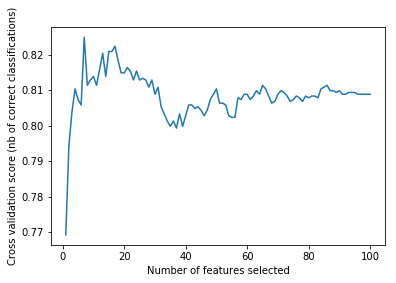


SVC linear kernel with CV feature selection on clean data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the SVC linear kernel with CV feature selection on clean data model are: 
	accuracy              : 0.836900(±0.05)
	precision             : 0.881000(±0.05)
	recall                : 0.863200(±0.1)
	f1                    : 0.866400(±0.05)
Selection of optimal number of features for dirty data
Number of optimal features selected: 25
	Selected Features
	1. population
	2. householdsize
	3. racepctblack
	4. racePctWhite
	5. racePctHisp
	6. agePct12t21
	7. agePct65up
	8. numbUrban
	9. pctWWage
	10. pctWInvInc
	11. NumUnderPov
	12. PctEmplProfServ
	13. PctOccupManu
	14. MalePctDivorce
	15. TotalPctDiv
	16. PctFam2Par
	17. PctKids2Par
	18. PctYoungKids2Par
	19. PctIlleg
	20. PersPerOccupHous
	21. HousVacant
	22. PctHousNoPhone
	23. RentLowQ
	24. RentHighQ
	25. LemasSwornFT


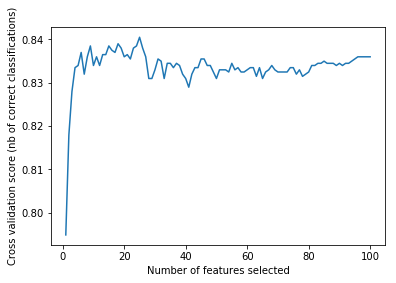


SVC linear kernel with CV feature selection on dirty data performace on cross validation:

The 10-fold cross-validation accuracy, precision, recall, f1 for the SVC linear kernel with CV feature selection on dirty data model are: 
	accuracy              : 0.843500(±0.01)
	precision             : 0.881800(±0.02)
	recall                : 0.867300(±0.02)
	f1                    : 0.874300(±0.01)


In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

def fit_RFECV(model_object, train_data, target_data):
    # Create the RFE object and compute a cross-validated score.
    # The "accuracy" scoring is used to select the features
    rfecv = RFECV(estimator=model_object, step=1, cv=StratifiedKFold(),scoring='accuracy')
    rfecv.fit(train_data, target_data)
    feature_ranks = sorted(list(zip(predictor_variables_dirty, rfecv.ranking_ )), key=lambda x :x[1], reverse=False)
    selected_features = []
    print("Number of optimal features selected: {}".format(rfecv.n_features_))
    print ('\tSelected Features')
    for i, feature_rank in enumerate(feature_ranks[:rfecv.n_features_]):
        print ("\t{}. {}".format(i+1, feature_rank[0]))
        selected_features.append(feature_rank[0])

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    return selected_features


# setting variables for easy access
X_clean, y_clean = clean_data_df[predictor_variables], clean_data_df[target_variable_clf]
X_dirty, y_dirty = full_data_df[predictor_variables], full_data_df[target_variable_clf]

# Classifier used for RFECV
svc_lin = SVC(kernel="linear", random_state =210, cache_size=400)

print("Selection of optimal number of features for clean data")
clean_features_selected = fit_RFECV(copy.deepcopy(svc_lin), X_clean, y_clean)

model_name_svc_4 = 'SVC linear kernel with CV feature selection on clean data'
# 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers[model_name_svc_4]=CS595ModelClassificationScoring(copy.deepcopy(svc_lin), 
                                                                          clean_data_df[clean_features_selected], y_clean, 
                                                                          model_name_svc_4)
scorers[model_name_svc_4].cross_validate()


model_name_svc_5 = 'SVC linear kernel with CV feature selection on dirty data'
print("Selection of optimal number of features for dirty data")
dirty_features_selected = fit_RFECV(copy.deepcopy(svc_lin), X_dirty, y_dirty)
               

# # 10-fold cross-validation accuracy, precision, recall and f1 average scores 
scorers[model_name_svc_5] = CS595ModelClassificationScoring(copy.deepcopy(svc_lin), 
                                                                      full_data_df[dirty_features_selected], y_dirty, 
                                                                      model_name_svc_5)
scorers[model_name_svc_5].cross_validate()

### Performance of SVM with linear kernel and cross-validated feature selection
Here we can see that performace of SVM esily outperforms the best performing models using only a fraction of the predictor variables for both data sets. This again highlights how important feature selection is in the process of model building.

### Best peforming model
For me the best performing model is Logistic Regression with cross-validation based feature selection. This model is not only very fast to compute but it is also easier to interpret. It is a bit unfair to compare it to other models that have not been tuned such as decision trees, extra trees and gradient boosting. But I prefer this because it gives a sufficiently high level of performance without needing many predictor variables and usinf minimal computation resources. So even though the SVC linear kernel with CV feature selection model slighthly outperforms the logistic regression I chose it because the model is a simpler one.

### Most common high importance features
The top 5 most features that have consistent high importance are:
1.PctKids2Par
2. racePctWhite
3. racePctHisp 
4. HousVacant
5. MalePctDivorce

Most of the models have differnt approches in how they treat correlated variables and how they calculate importance. All these methods capture different forms of predictive power that the varibles possess. So if these variables are showing up consistently as high importance features in multiple models and also when feature selection techniques are applied then its highly reliable that these variables are actually of high importance in predicting crime. 